In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# load modules related to this exercise
import Exercise_1 as ex1

# Exercise 1: Time iteration

Consider the model
$$\begin{align*}
V_{t}(M_{t}) & = & \max_{C_{t}}\left\{ \frac{C_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[V_{t+1}(M_{t+1})\right]\right\} \\
 & \text{s.t.}\\
M_{t+1} & = & R(M_{t}-C_{t})+Y_{t+1}\\
Y_{t+1} & = & \exp(\xi_{t+1})\\
\xi_{t+1} & = & \mathcal{N}(\mu,\sigma_{\xi}^{2})\\
A_{t}=M_{t}-C_{t} & \geq & 0
\end{align*}$$

for $T=10$, $\beta=0.98$, $\rho=0.5$, $R=1.0/\beta$, $M_1=10$ and $\sigma_{\xi}=0.2$.

### 1. Solve the model using time iteration. Remember that optimal consumption must satisfy the Euler-equation:
$$\begin{align*}
u'(C_t) = \beta R \mathbb{E}_t[u'(C_{t+1}^{\star}(M_{t+1}))]
\end{align*}$$

In [2]:
# Setup
par = ex1.setup()
# Solve
sol = ex1.solve_ti(par)

c:\Users\PC\OneDrive\Skrivebord\dynamic\Dynamic-programming\3_discrete_continuous_choice\exercises\ex_ante\Exercise_1.py:11: RuntimeWarning: invalid value encountered in power
  return c**(-par.rho)


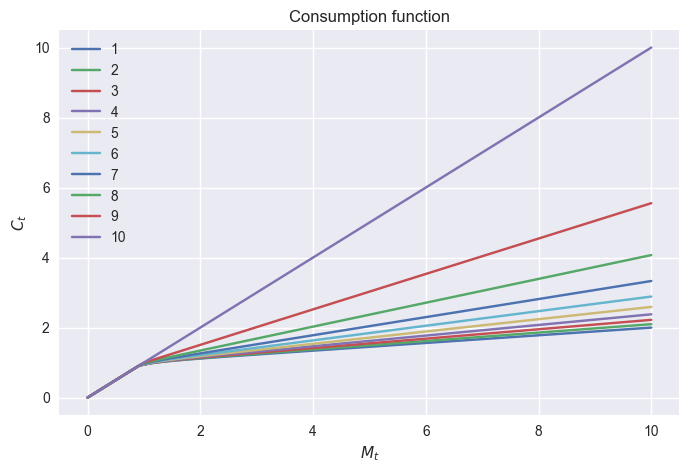

In [12]:
# Print consumption function

fig = plt.figure(figsize=(8,5))# figsize is in inches...
ax = fig.add_subplot(1,1,1)
for t in range(par.T):
    ax.plot(par.grid_M,sol.C[:,t], label=t+1)
ax.set_xlabel(f"$M_t$")
ax.set_ylabel(f"$C_t$")
ax.set_title(f'Consumption function')
plt.legend()

plt.show()

### 2. Simulate a panel of *N=10000* household for *T=10* periods and plot the mean of $C_t$. Everybody should be initialized with $W_t = 1.5$.

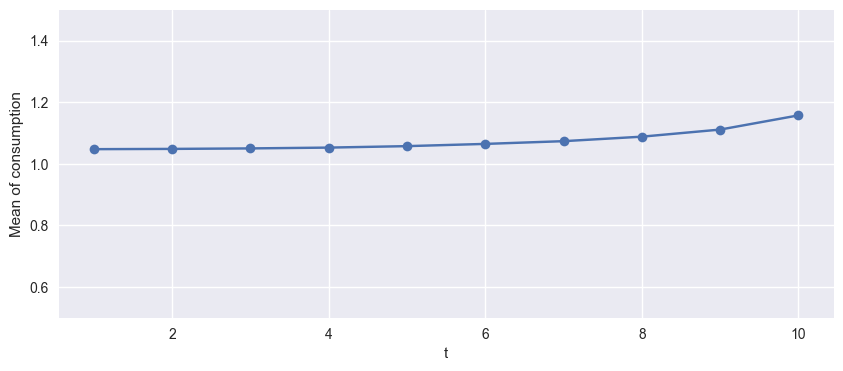

In [3]:
sim = ex1.simulate(par,sol)

def figure_sim(simC,par):
    fig = plt.figure(figsize=(10,4))# figsize is in inches...
    t_grid = [t for t in range(1,par.T+1)]    
    ax = fig.add_subplot(1,1,1)
    ax.plot(t_grid,np.mean(simC,0),'-o')
    ax.set_xlabel(f"t")
    ax.set_ylabel(f"Mean of consumption")
    ax.set_ylim(bottom=0.5,top=1.5)
    plt.show()
    
figure_sim(sim.C,par)

### 3. Calculate the Euler-error and the normalized Euler-error


#### Recall the Euler-error:

$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T}  \mathbb{1}_{\{0<C_1<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<W_{it}\}} |\varepsilon_{it}|
 \end{align*}$$
 where

$$\begin{align*}
  \varepsilon_{it} \approx u'(C_{it})-\beta R \sum_{j=1}^{S} \omega_j \Big[u'\big(C_{t+1}^{\star}(R(W_{it}-C_{it})+Y_j)\big)\Big]
 \end{align*}$$
 
 and $\omega_j$ are the Gauss-Hermite weights and $Y_j$ are the associated income nodes.
 
#### Recall the normalized Euler-error:


$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} log_{10}(|\varepsilon_{it}| / C_{it}) \mathbb{1}_{0<C_1<W_{it}} 
 \end{align*}$$


In [4]:
Euler_residual = np.nan + np.zeros((par.simN,par.T-1))
A = np.nan + np.zeros((par.simN,par.T-1))

# Calculate Euler error
for t in range(par.T-1):
    m = sim.M[:,t]
    c = sim.C[:,t]
    A[:,t] = m-c


    m_next = par.R*(m - c)[:,np.newaxis]+par.eps[np.newaxis,:]
    interp = interpolate.interp1d(par.grid_M,sol.C[:,t+1], bounds_error=False, fill_value = "extrapolate") 
    c_next = interp(m_next)
    EU_next = np.sum(par.eps_w[np.newaxis,:]*ex1.marg_util(c_next,par), axis=1)
    U_now = ex1.marg_util(c,par) 
    Euler_residual[:,t] = U_now-par.beta*par.R*EU_next
    
#Handle edge cases
I = (A>0)   # Define an indicator for A bigger than 0

#Calculate mean Euler error for interior points
Euler_error = np.mean(abs(Euler_residual[I]))
print(f'The Euler error:    {Euler_error:.5f}')


# Calculate the normalized Euler error
C =(sim.C[:,0:par.T-1])
nom_Euler_error = np.log10(abs(Euler_residual[I])/(C[I]))   
nom_Euler_error = np.mean(nom_Euler_error)


print(f'The Normalized Euler error:    {nom_Euler_error:.5f}')

The Euler error:    0.00037
The Normalized Euler error:    -4.87412


What is the Euler error? Why is it not exact zero?